# Project Milestone One: Gathering your Team, Understanding the Problem,  Exploring the Data

## Due: Midnight on March 30 (with 2-hour grace period) and worth 25 points





### What We Will Do in This Milestone Assignment

1. You will convene your team (listed on Blackboard) and fill out the Team Contract (in the Homework Repo), to be submitted to Gradescope.
2. You must select a team leader for the purpose of submitting this notebook, after the team collaborates to complete the assignment. The team leader should upload the notebook and then create a group on GS for the group submission.
3. At the conclusion of your work on this Milestone, you will complete an Individual Evaluation of your team's work (in the Homework Repo) and upload it *individually* to Gradescope.
4. We will follow a simplified version of the **Machine Learning Project Checklist** in Appendix A in our textbook *Hands-On Machine Learning* (pp.779):  

>Part 1:	Frame the problem and look at the big picture  
Part 2: Download and perform preliminary exploration of the data  
Part 3: Clean the Data: Drop, Impute, and Encode   
Part 4: Explore Feature Relationships  
Part 5: Investigate Feature Engineering options to better expose the underlying data patterns  

### The Dataset

All teams will use the same dataset. It is a smaller version of the Zillow housing dataset that was used in the
Zillow Million Dollar Prize which ran on Kaggle in 2017 (sorry, the contest is closed, so you can't win any money
with this project!).  We will try to predict the assessed tax value (`'taxvaluedollarcnt'`) of the property from a large collection
of descriptors. Some features are closely related and some are obviously useless.  There are potential outliers and also quite a few missing values. 

This is a good example of a dataset which has not been predigested for you on Kaggle, and should give you a good chance to
try all the various tools in your toolbox!


In [370]:
# =============================
# Useful Imports
# =============================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations
from matplotlib.ticker import ScalarFormatter

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Kaggle and Progress Tracking
import kagglehub
from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



## Prelude: Download the Zillow Housing Dataset 

The code cell below will load the dataset for you.    

> **Notice that before downloading, this cell first checks whether the files already exist.** 

For a detailed description of the dataset features, please refer to  **Appendix 1** below. 

**Note:** Do **not** perform a train/test split for this milestone (unlike HOML suggests), since you need to do the split **after** any data preparation and feature engineering. You can wait until Milestone 2 to do the split. 

In [371]:

url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/zillow_dataset.csv"

filename = os.path.basename(urlparse(url).path)

if not os.path.exists(filename):
    try:
        print("Downloading the file...")
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        with open(filename, "wb") as f:
            f.write(response.content)
        print("File downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print("File already exists. Skipping download.")

df = pd.read_csv(filename)

File already exists. Skipping download.


## Part 1: Frame the problem and look at the big picture [3 pts]

This part is a bit vague, since this project is not taking place in an actual business, but for the sake of exercizing all the steps, **pretend** that you are working at Zillow as a data analyst and are given this dataset and asked to
- Analyze and understand the data; 
- Create a regression model;
- Give a presentation to the marketing team about your results.  

#### **1 Discussion:** 

AFTER doing your EDA, come back and answer each of the following 3 questions in a *concise and informative paragraph between the lines;* you may wish to use your own business or home-buying experience, or to do some online research about the issues before you propose your ideas. (Don't stress about this, but *humor your professor and give it your best shot!*)


**1.1:**  What is the objective of this project in business terms?


Objective of the Zillow Prize was to improve upon the existing "Zestimate" model that analysis and predicts the value of a house. Zillow wanted to have a model that can most accurately predict a house price to increase the traffic to their website and grow their customer/client base. 

This in turn will provide Zillow more database about their customers/clients which in turn will further improve their model.

For our group - Zillow Prize database opportunities great opportunity to apply the tools and knowledge gained during our program. The Zillow Prize database provides ample opportunity to clean, pre-process, analyze, and predict with a fairly simple to understand structure. We also personally hope to improve upon the prize winning model which proved to be not suitable to handle outlier events like COVID. Maybe we will eventually be able to build a modle that works along side market sentiment, federal rates prediction, and general supply and demand.

**1.2:**  How will your solution be used?


For household users, our model provides important guide on how much they can expect their houses to be worth, how much they would need to save up to afford a future home, or how much they can expect house prices to raise/fall in the coming years. It also provides a guide on the range for the price so they do not over/under pay for a house.

For enterprise users, it provides the same data but large investors, developers, and politicians may collect these data to view a trend over a larger time frame and geopolitical region. For example, developers can analyse the cost-basis for turning a single-home community to a apartment or politicians might try to observe changes in home values in certain communities.

**1.3:**  How should success (or failure) be measured?


## Part 2: Download and perform preliminary exploration of the data [4 pts]

### Part 2.A: Load the data into a dataframe and study each feature/column and its characteristics:
- Name
- Type (categorical, int/float, text, etc.)
- Apparent usefulness for the task
- Approximate % of missing values
- How many unique values

**Note:** The **target** is the last column `'taxvaluedollarcnt'` -- pay particular attention to this during the EDA process. 
  
Hint: Just use `.head()`, `.info()`, and `.nunique()`.

In [372]:
df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,assessmentyear,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,taxvaluedollarcnt
0,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,...,NaN,NaN,1998.0,NaN,NaN,2016.0,NaN,NaN,6.059063e+13,1023282.0
1,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,...,NaN,NaN,1967.0,1.0,NaN,2016.0,NaN,NaN,6.111001e+13,464000.0
2,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,...,NaN,NaN,1962.0,1.0,NaN,2016.0,NaN,NaN,6.059022e+13,564778.0
3,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1970.0,NaN,NaN,2016.0,NaN,NaN,6.037300e+13,145143.0
4,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1964.0,NaN,NaN,2016.0,NaN,NaN,6.037124e+13,119407.0


In [373]:

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77613 non-null  int64  
 1   airconditioningtypeid         25007 non-null  float64
 2   architecturalstyletypeid      207 non-null    float64
 3   basementsqft                  50 non-null     float64
 4   bathroomcnt                   77579 non-null  float64
 5   bedroomcnt                    77579 non-null  float64
 6   buildingclasstypeid           15 non-null     float64
 7   buildingqualitytypeid         49809 non-null  float64
 8   calculatedbathnbr             76963 non-null  float64
 9   decktypeid                    614 non-null    float64
 10  finishedfloor1squarefeet      6037 non-null   float64
 11  calculatedfinishedsquarefeet  77378 non-null  float64
 12  finishedsquarefeet12          73923 non-null  float64
 13  f

In [374]:
df.nunique()

parcelid                        77414
airconditioningtypeid               5
architecturalstyletypeid            5
basementsqft                       43
bathroomcnt                        22
bedroomcnt                         16
buildingclasstypeid                 2
buildingqualitytypeid              12
calculatedbathnbr                  21
decktypeid                          1
finishedfloor1squarefeet         1787
calculatedfinishedsquarefeet     4972
finishedsquarefeet12             4868
finishedsquarefeet13               13
finishedsquarefeet15             1724
finishedsquarefeet50             1807
finishedsquarefeet6               350
fips                                3
fireplacecnt                        5
fullbathcnt                        13
garagecarcnt                       14
garagetotalsqft                   839
hashottuborspa                      1
heatingorsystemtypeid              10
latitude                        64038
longitude                       62461
lotsizesquar

In [375]:
missing_percentage = df.isnull().mean() * 100
print(missing_percentage)

parcelid                         0.000000
airconditioningtypeid           67.779882
architecturalstyletypeid        99.733292
basementsqft                    99.935578
bathroomcnt                      0.043807
bedroomcnt                       0.043807
buildingclasstypeid             99.980673
buildingqualitytypeid           35.823895
calculatedbathnbr                0.837489
decktypeid                      99.208895
finishedfloor1squarefeet        92.221664
calculatedfinishedsquarefeet     0.302784
finishedsquarefeet12             4.754358
finishedsquarefeet13            99.945885
finishedsquarefeet15            96.099880
finishedsquarefeet50            92.221664
finishedsquarefeet6             99.502661
fips                             0.043807
fireplacecnt                    89.320088
fullbathcnt                      0.837489
garagecarcnt                    67.118910
garagetotalsqft                 67.118910
hashottuborspa                  98.017085
heatingorsystemtypeid           36

#### **2.A Discussion:** Answer the following questions.

**2.A.1:**  Which features are categorical?


Following features are catagorical: 'airconditioningtypeid','architecturalstyletypeid','buildingqualitytypeid','buildingclasstypeid','decktypeid','fips',<br>'heatingorsystemtypeid','pooltypeid10','pooltypeid2','pooltypeid7','propertylandusetypeid','regionidcounty',<br>'regionidcity','regionidneighborhood','typeconstructiontypeid'

**2.A.2:**  Are there any features which appear at first glance to be **useless** for the business purpose of this project and should be deleted?  Give examples and describe your reasoning briefly. 

There are a few explicitly useless features and a couple which make other related features redundant. <br>
For example parcelid serves as a unique identifier for the database so it will be unnecessary to run this through the model. Also there are numerous geo-location features like latitude, longitude, fips, census block, and full address. Census block,zip, and assign neighborhood info should give database enough data to work with, and other database can be dropped.

**2.A.3:**  Are there any features which appear to be **useless** because of the percentage of missing values?  If so, give an example. 

There were many features that had incomplete data collection done on the row. This is okay if there are enough samples of correctly identified features but if there are large percentage of collected data has missing columns it would lead to statistical errors. Following features had this problem:'architecturalstyletypeid','basementsqft','buildingclasstypeid','decktypeid',finishedsquarefeet13,finishedsquarefeet6,finishedsquarefeet15,'storytypeid','yardbuildingsqft26'.
Another feature was identified with nonsensical data collection, 'fireplaceflag', where 'fireplacecnt' was higher thant the fireplaceflag. 

**2.A.4:**  Are there any features which appear to be **useless** because of the number of unique values?  If so, give an example. 

Expectedly, volumne/area calcuations had very many large numbers. But we should assign these to appropriate bins - not drop them completely. Similarly, I had previously mentioned that geo-locating features can be reduced to 'census block', 'zip', and 'assigned neighborhood'. Latitude and Longitutde information is too detailed for statistical imputation and redundant. 

### Part 2.B: Exploratory Data Analysis (EDA) -- Feature-Level Visualization  

- To get an overview, generate histograms for all features using `df.hist()`  (Hint: increase the figsize and set the layout to `(-1,m)` to get  `m` columns and as many rows as necessary.)
- Generate individual visualizations for the **target and three (3)** other interesting-looking features in the dataset (i.e., a total of 4):  
    - Use appropriate plot types (e.g., histograms and boxplots for numerical features, bar plots for categorical features) to understand distributions and identify potential outliers for these three.
    - Use as many code cells as you need, and give comments describing what each cell does.
    - Answer the discussion question posed (you should choose 3 features for which you can say something interesting in the discussion).  

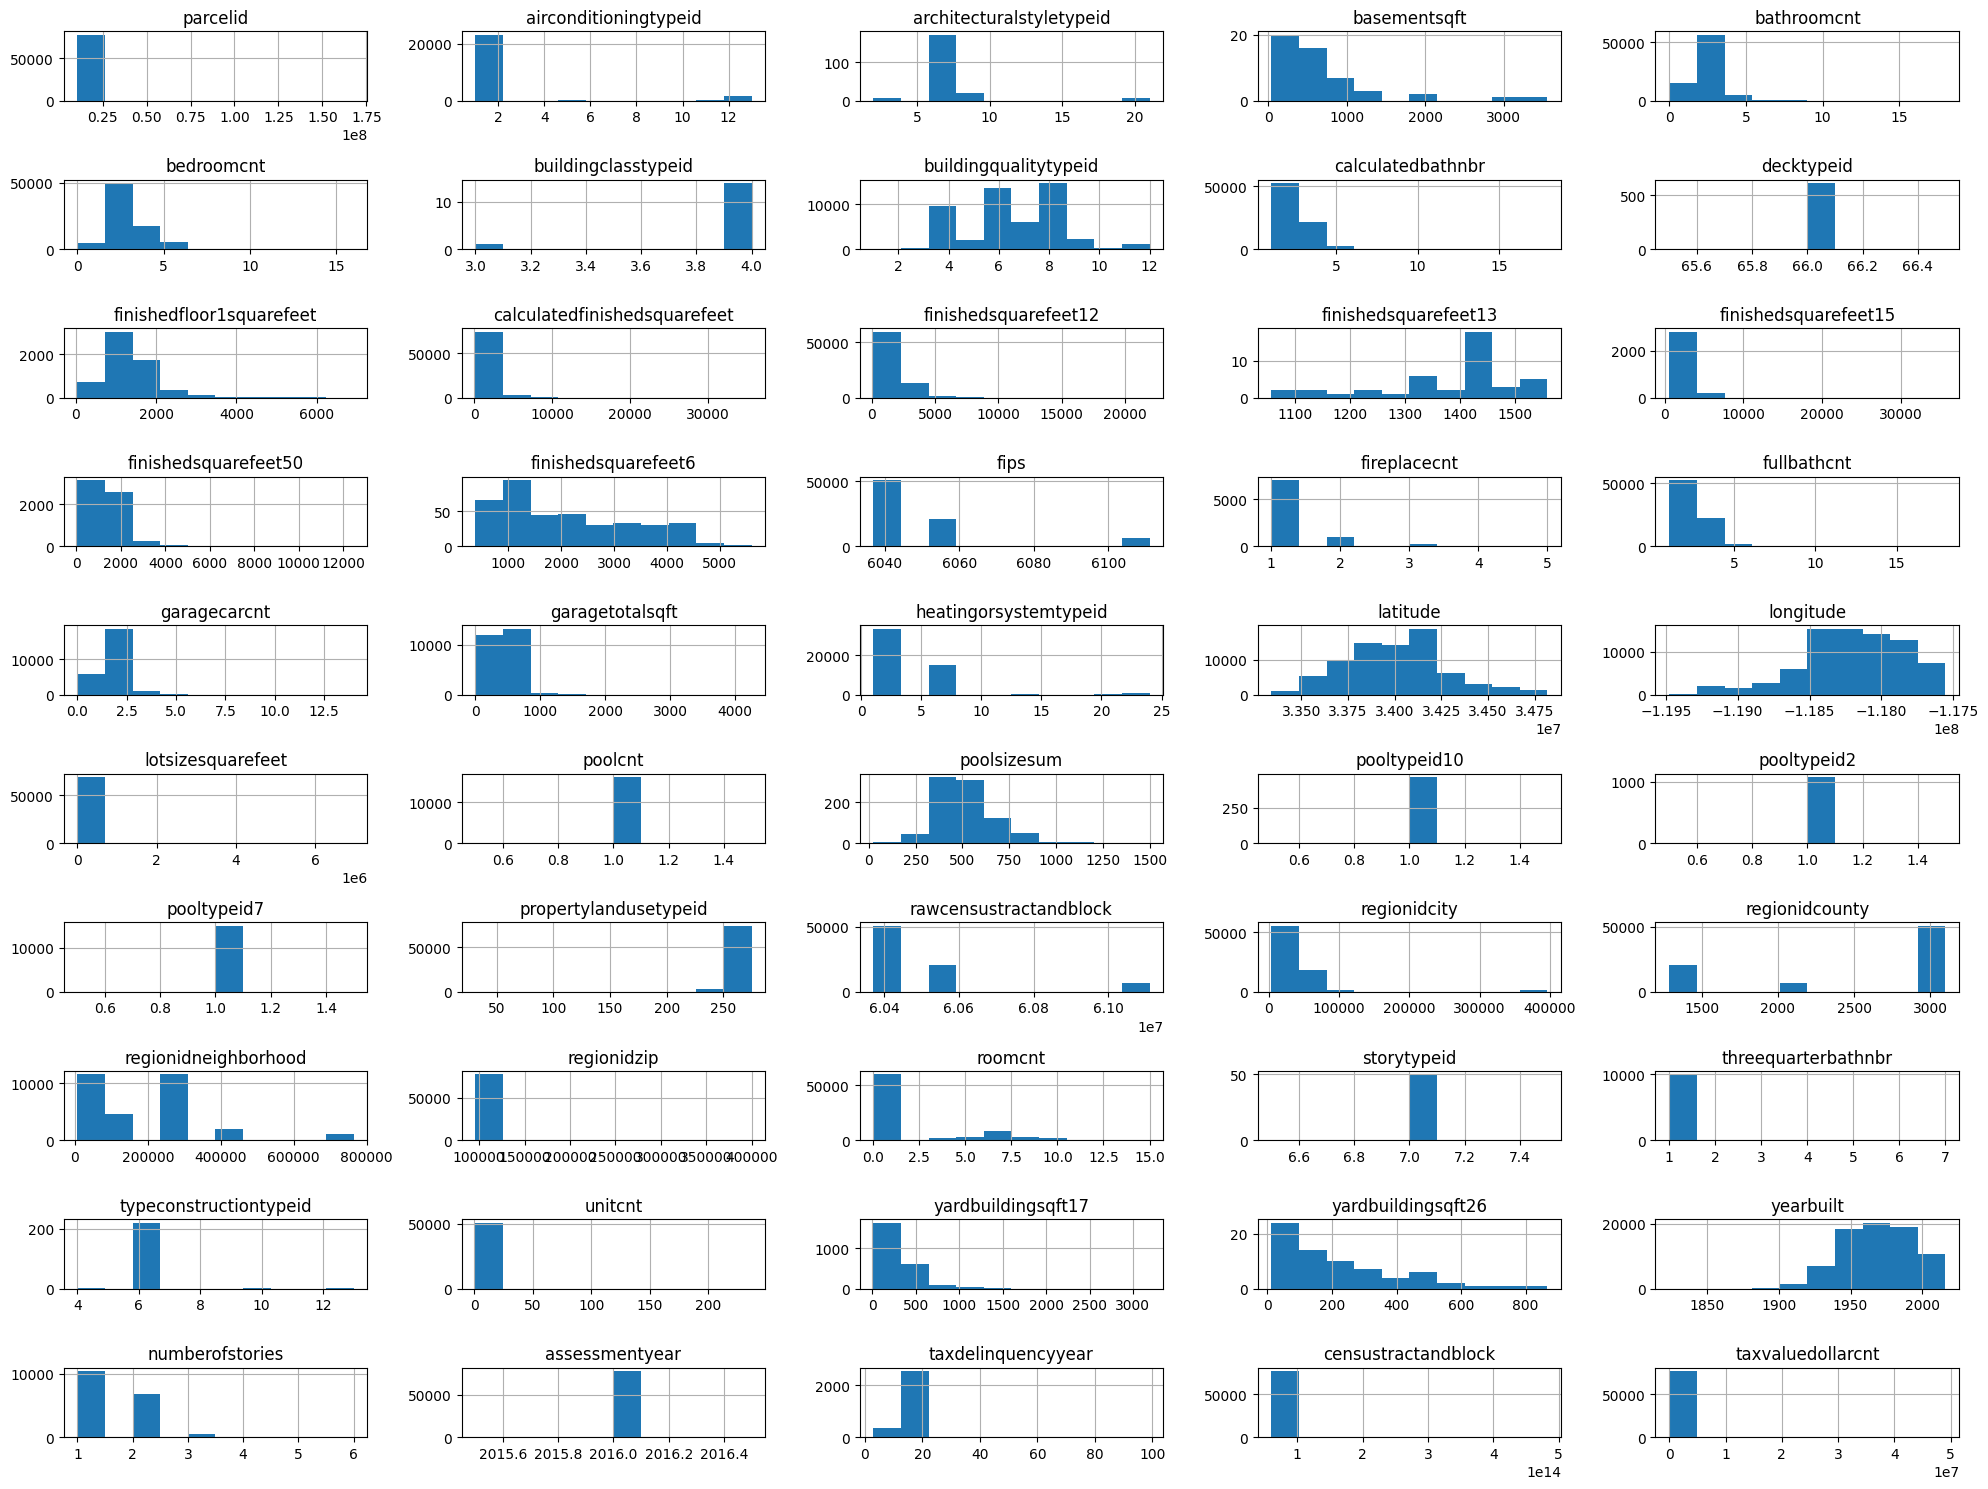

In [376]:
df.hist(figsize=(20, 15), layout=(-1, 5))  #overall distribution.
plt.tight_layout()
plt.show()


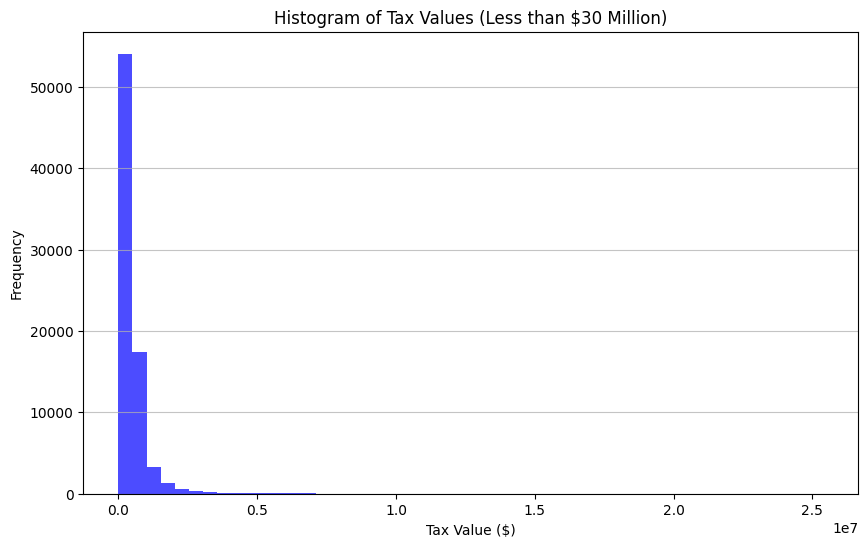

In [377]:
# Filter the dataset for houses with tax values less than $30 million since the outliers impact the graph too greatly/.
filtered_df = df[df['taxvaluedollarcnt'] < 30000000]

plt.figure(figsize=(10, 6))
plt.hist(filtered_df['taxvaluedollarcnt'], bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Tax Values (Less than $30 Million)')
plt.xlabel('Tax Value ($)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

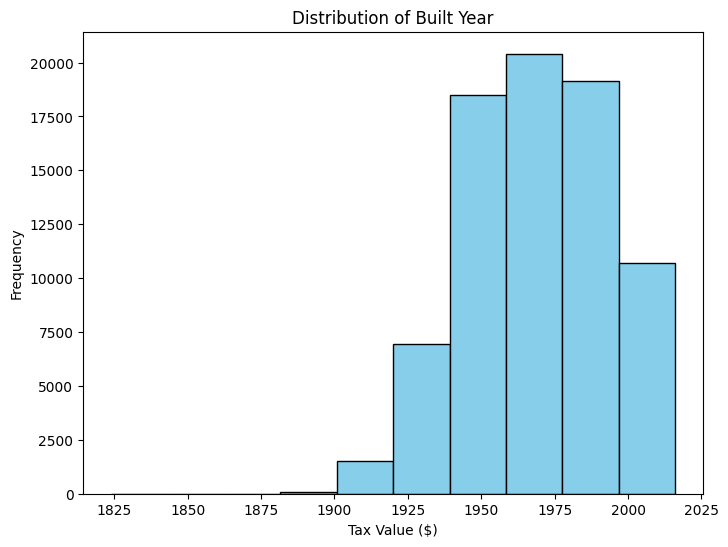

In [378]:
#built year is one of the more important features.
plt.figure(figsize=(8, 6))
df['yearbuilt'].plot(kind='hist', color='skyblue', edgecolor='black')
plt.title('Distribution of Built Year')
plt.xlabel('Tax Value ($)')
plt.ylabel('Frequency')
plt.show()

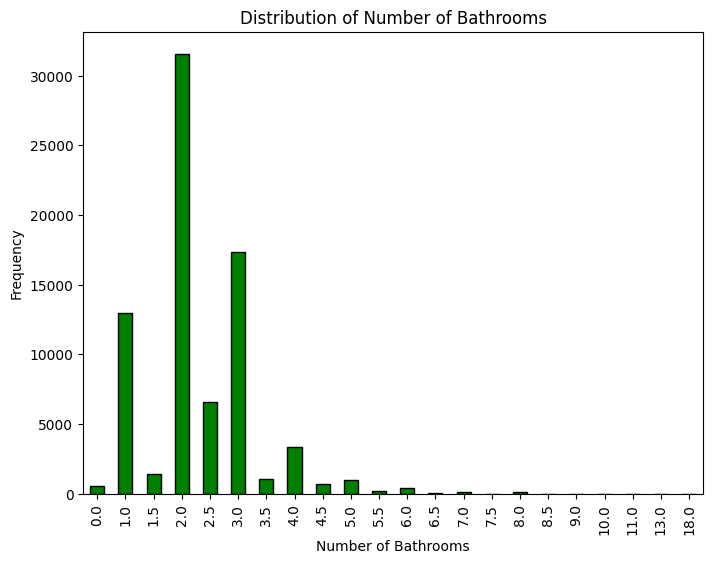

In [379]:
plt.figure(figsize=(8, 6))
df['bathroomcnt'].value_counts().sort_index().plot(kind='bar', color='green', edgecolor='black')
plt.title('Distribution of Number of Bathrooms')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Frequency')
plt.show()


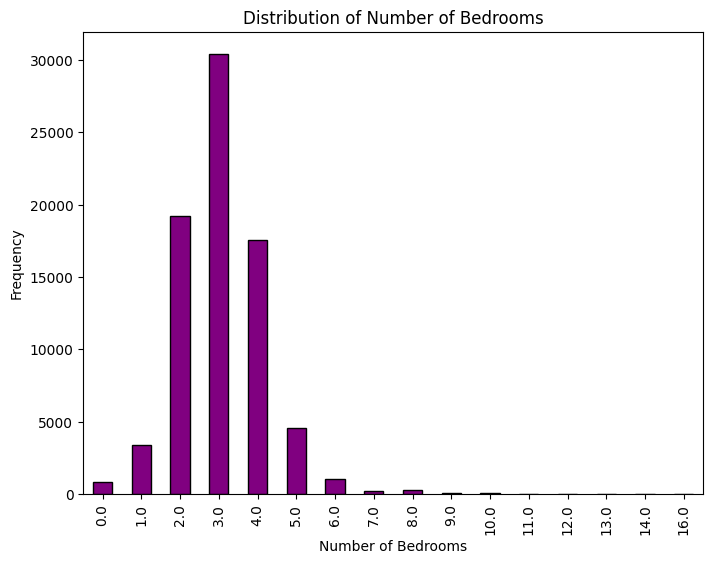

In [380]:
plt.figure(figsize=(8, 6))
df['bedroomcnt'].value_counts().sort_index().plot(kind='bar', color='purple', edgecolor='black')
plt.title('Distribution of Number of Bedrooms')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Frequency')
plt.show()

#### **2.B Discussion:** Describe in a paragraph what you learned in your detailed examination of the features you explored:
- What is the distribution (normal, exponential, etc.) if any?
- Any problems (e.g., outliers, any odd characteristics)?
- Anything else interesting? Why did you choose it?


Distribution of property tax values was skewed to the lower end of the values with extreme outliers reaching 50 million dollars. Even when this outlier was removed there were many outliers beyond 15 million dollars that impacted the distribution curve of the graph. But most homes were valued less than 1 million. This fact might prove valuing higher end homes more difficult as there are less samples to work with. 

Distribution of year built showed normal distribution but there were outliers older than 1900, which we may want to remove for general value calculation or supplement with 'remodeled year' As these houses are beyond their natural lif-cycle. 

Number of bathrooms showed an interesting distribution where distribution is normal when the half bathroom houses were ignored but adding half bathrooms makes the distributed varied. It is interesting to note that there were also houses without any bathrooms, which we would need to consider when doing our research.

Similarly to number of bathrooms, number of bedrooms also showed a normal distributions. And same as bathrooms, there were houses without bedrooms.

## Part 3:  Clean the Data: Drop, Impute, and Encode [6 pts]



**Important Notes:**
- You should review your Homework 4 before doing this section!
- Create new names for modified data at each stage to avoid problems with global variables.
- Whenever possible, write functions for all data transformations you apply, for these reasons:
    - So you can easily prepare the data the next time you get a fresh dataset
    - So you can apply these transformations in future projects
    - To clean and prepare new data instances once your solution is live
    - To make it easy to treat your preparation choices as hyperparameters
    - [To apply the same transformations to your test set if train/test split already done -- not applicable here]

### Part 3.A: Drop features you judge to be unsuitable for the regression task

Your call, based on any research you can do to understand the feature (hopefully IRL you would have a domain expert to help with this, but do your best).   

Note: Do not drop features because of too many missing values, that's the next task! 

In [381]:
columns_to_drop = [
    'latitude', 'longitude', 'regionidneighborhood', 'regionidcounty', 'regionidcity', 'fips'
]

# Drop the columns
df.drop(columns=columns_to_drop, inplace=True)

# Display the first few rows of the updated DataFrame
print(df.head())

   parcelid  airconditioningtypeid  architecturalstyletypeid  basementsqft  \
0  14297519                    NaN                       NaN           NaN   
1  17052889                    NaN                       NaN           NaN   
2  14186244                    NaN                       NaN           NaN   
3  12177905                    NaN                       NaN           NaN   
4  10887214                    1.0                       NaN           NaN   

   bathroomcnt  bedroomcnt  buildingclasstypeid  buildingqualitytypeid  \
0          3.5         4.0                  NaN                    NaN   
1          1.0         2.0                  NaN                    NaN   
2          2.0         3.0                  NaN                    NaN   
3          3.0         4.0                  NaN                    8.0   
4          3.0         3.0                  NaN                    8.0   

   calculatedbathnbr  decktypeid  ...  yardbuildingsqft17  yardbuildingsqft26  \
0    

#### **3.A Discussion:** Justify in a paragraph your decisions about which features to drop. 


The features dropped were summation of analysis done on the columns in Part 2. Many geo-location features were redundant, features with 98% or more NaN rows that had no significant impact were removed. Along with 'fireplaceflag' which were also redundant and showed too many missing values to its comparable feature 'fireplacecount.'

### Part 3.B: Drop **features** with "too many" null values

Your code in the next cell(s). Make a judgement call about what "too many" means and briefly describe your reasoning in the discussion.   

Note: "Too many" may depend on what the non-null values look like, be sure to investigate carefully. 

In [382]:

missing_to_drop = ['architecturalstyletypeid', 'basementsqft', 'buildingclasstypeid', 
'decktypeid', 'finishedsquarefeet13', 'finishedsquarefeet6', 'finishedsquarefeet15',
'storytypeid', 'yardbuildingsqft26', 'fireplaceflag','typeconstructiontypeid','finishedsquarefeet50','finishedfloor1squarefeet','yardbuildingsqft17','poolsizesum', 
'pooltypeid10','pooltypeid2','pooltypeid7']

# Drop the columns
df.drop(columns=missing_to_drop, inplace=True)

# Display the first few rows of the updated DataFrame
print(df.head())

   parcelid  airconditioningtypeid  bathroomcnt  bedroomcnt  \
0  14297519                    NaN          3.5         4.0   
1  17052889                    NaN          1.0         2.0   
2  14186244                    NaN          2.0         3.0   
3  12177905                    NaN          3.0         4.0   
4  10887214                    1.0          3.0         3.0   

   buildingqualitytypeid  calculatedbathnbr  calculatedfinishedsquarefeet  \
0                    NaN                3.5                        3100.0   
1                    NaN                1.0                        1465.0   
2                    NaN                2.0                        1243.0   
3                    8.0                3.0                        2376.0   
4                    8.0                3.0                        1312.0   

   finishedsquarefeet12  fireplacecnt  fullbathcnt  ...  roomcnt  \
0                3100.0           NaN          3.0  ...      0.0   
1                1465.

#### **3.B Discussion:** In a paragraph, explain your decision about which features were dropped



The features dropped above were dropped as they appeared to be data that was not reported. For example, 'architecturalstyletypeid' had 99.73% missing values but all houses follow a certain style, so it would not make sense to impute a certain value based on the 0.3 reported value. Similarly, many of the square footage features had the same problem. For example, 20 percent of the houses were reported to have a pool but only 2 percent had footage of the pool reported. And since these features had very large misisng values, assuming any value for them would prove statistically improper.

### Part 3.C: Drop Problematic **samples** 

There could be several reasons why you might want to drop a sample:
- It has  "too many" null values 
- It has a null value in the target
- It contains outliers, especially in the target



Your code in the next cell(s). Make a judgement call about which samples should be dropped and briefly describe your reasoning in the discussion.   


In [383]:
houses_over_30_million = df[df['taxvaluedollarcnt'] > 20000000]
count_before = len(houses_over_30_million)

print(f"Number of houses worth over 30 million before dropping: {count_before}")

# Drop rows where taxvaluedollarcnt is over 30 million
df = df[df['taxvaluedollarcnt'] <= 20000000]

# Verify the drop by counting again
count_after = len(df[df['taxvaluedollarcnt'] > 20000000])

print(f"Number of houses worth over 30 million after dropping: {count_after}")

# Display the shape of the DataFrame before and after dropping
print(f"DataFrame shape before dropping: {df.shape[0]} rows")

# Optional: Reset the index of the DataFrame
df = df.reset_index(drop=True)

print("\nFirst few rows of the updated DataFrame:")
print(df.head())

Number of houses worth over 30 million before dropping: 6
Number of houses worth over 30 million after dropping: 0
DataFrame shape before dropping: 77572 rows

First few rows of the updated DataFrame:
   parcelid  airconditioningtypeid  bathroomcnt  bedroomcnt  \
0  14297519                    NaN          3.5         4.0   
1  17052889                    NaN          1.0         2.0   
2  14186244                    NaN          2.0         3.0   
3  12177905                    NaN          3.0         4.0   
4  10887214                    1.0          3.0         3.0   

   buildingqualitytypeid  calculatedbathnbr  calculatedfinishedsquarefeet  \
0                    NaN                3.5                        3100.0   
1                    NaN                1.0                        1465.0   
2                    NaN                2.0                        1243.0   
3                    8.0                3.0                        2376.0   
4                    8.0           

#### **3.C Discussion:** In a short paragraph, explain your decision about which samples were dropped


There were only 6 houses valued over 20 millions dollars. Out of 77578 samples, this number is too insignificant to consider into the prediction model. It would skew the numbers greatly out of the norm.

### Part 3.D: Impute for the remaining missing values

Review the methods for imputation in **Appendix 2** and choose how you will impute the remainder of the missing values. Note:
- Consider whether different methods are justified for different features.
- In the next cells, apply your imputation methods to the dataset so that no null values remain after this step.
- Answer the discussion question.

In [384]:
missing_percentage = df.isnull().mean() * 100
print(missing_percentage)



parcelid                         0.000000
airconditioningtypeid           67.769298
bathroomcnt                      0.000000
bedroomcnt                       0.000000
buildingqualitytypeid           35.795132
calculatedbathnbr                0.794101
calculatedfinishedsquarefeet     0.259114
finishedsquarefeet12             4.713041
fireplacecnt                    89.314443
fullbathcnt                      0.794101
garagecarcnt                    67.102821
garagetotalsqft                 67.102821
hashottuborspa                  98.016037
heatingorsystemtypeid           36.104522
lotsizesquarefeet               10.644305
poolcnt                         79.158717
propertycountylandusecode        0.000000
propertylandusetypeid            0.000000
propertyzoningdesc              34.937864
rawcensustractandblock           0.000000
regionidzip                      0.064456
roomcnt                          0.000000
threequarterbathnbr             86.972103
unitcnt                         34

In [385]:
#'count' and 'flag' type values filled with 0 to indicate no hits on the row.
columns_to_fill = [
    'airconditioningtypeid',
    'buildingqualitytypeid',
    'fireplacecnt',
    'garagecarcnt',
    'garagetotalsqft',
    'fullbathcnt',
    'lotsizesquarefeet',
    'heatingorsystemtypeid',
    'poolcnt',
    'threequarterbathnbr',
    'taxdelinquencyflag',
    'taxdelinquencyyear',
    'hashottuborspa',
    
]

df[columns_to_fill] = df[columns_to_fill].fillna(0)

for column in columns_to_fill:
    print(f"NaN count in {column}: {df[column].isna().sum()}")

print("\nFirst few rows of the updated DataFrame:")
print(df[columns_to_fill].head())

NaN count in airconditioningtypeid: 0
NaN count in buildingqualitytypeid: 0
NaN count in fireplacecnt: 0
NaN count in garagecarcnt: 0
NaN count in garagetotalsqft: 0
NaN count in fullbathcnt: 0
NaN count in lotsizesquarefeet: 0
NaN count in heatingorsystemtypeid: 0
NaN count in poolcnt: 0
NaN count in threequarterbathnbr: 0
NaN count in taxdelinquencyflag: 0
NaN count in taxdelinquencyyear: 0
NaN count in hashottuborspa: 0

First few rows of the updated DataFrame:
   airconditioningtypeid  buildingqualitytypeid  fireplacecnt  garagecarcnt  \
0                    0.0                    0.0           0.0           2.0   
1                    0.0                    0.0           1.0           1.0   
2                    0.0                    0.0           0.0           2.0   
3                    0.0                    8.0           0.0           0.0   
4                    1.0                    8.0           0.0           0.0   

   garagetotalsqft  fullbathcnt  lotsizesquarefeet  heat

In [386]:
#rows with no reporeted separate units or stories assumed to be single unit.
columns_to_fill_one = [
   'unitcnt', 'numberofstories'
]
df[columns_to_fill_one] = df[columns_to_fill_one].fillna(1)

In [387]:
#spot check to make sure we are left with columns with 5 percent or less columns
missing_percentage = df.isnull().mean() * 100
print(missing_percentage)

parcelid                         0.000000
airconditioningtypeid            0.000000
bathroomcnt                      0.000000
bedroomcnt                       0.000000
buildingqualitytypeid            0.000000
calculatedbathnbr                0.794101
calculatedfinishedsquarefeet     0.259114
finishedsquarefeet12             4.713041
fireplacecnt                     0.000000
fullbathcnt                      0.000000
garagecarcnt                     0.000000
garagetotalsqft                  0.000000
hashottuborspa                   0.000000
heatingorsystemtypeid            0.000000
lotsizesquarefeet                0.000000
poolcnt                          0.000000
propertycountylandusecode        0.000000
propertylandusetypeid            0.000000
propertyzoningdesc              34.937864
rawcensustractandblock           0.000000
regionidzip                      0.064456
roomcnt                          0.000000
threequarterbathnbr              0.000000
unitcnt                          0

In [388]:
def map_unique_values(data):

    unique_values = sorted(list(set(data)))
    value_map = {val: index + 1 for index, val in enumerate(unique_values)}
    mapped_data = [value_map[val] for val in data]
    return mapped_data, value_map

In [389]:
#encode zoning desc in line
def map_unique_values(data):

    unique_values = list(set(data))
    value_map = {val: index + 1 for index, val in enumerate(unique_values)}
    mapped_data = [value_map[val] for val in data]
    return mapped_data, value_map

mapped_list, zone_encode_mapping = map_unique_values(df['propertyzoningdesc'])

print("Mapped list:", mapped_list)
print("Value mapping:", zone_encode_mapping)
#1827 is NaN
df['propertyzoningdesc']= mapped_list

Mapped list: [1827, 1827, 1827, 311, 1778, 1827, 88, 1169, 1458, 1778, 475, 1827, 1827, 1827, 1827, 1827, 1827, 140, 358, 1827, 113, 1827, 1827, 1283, 1323, 1141, 1827, 475, 425, 1827, 1684, 1827, 1615, 1386, 1827, 1778, 1827, 1615, 432, 1827, 1827, 1452, 1452, 425, 732, 612, 1778, 310, 314, 1452, 1827, 22, 1827, 264, 890, 1827, 1500, 1287, 1827, 1827, 1827, 911, 798, 1564, 1827, 1900, 1827, 1236, 1827, 1558, 1452, 1452, 1452, 47, 1827, 996, 765, 1633, 1686, 1500, 1827, 433, 737, 1827, 1452, 1827, 1050, 1827, 1211, 1827, 210, 1452, 1827, 1807, 1827, 1452, 1827, 1827, 472, 1303, 1827, 1236, 1827, 1827, 475, 1452, 99, 1827, 612, 1549, 1827, 1827, 1500, 1452, 1827, 1827, 425, 425, 264, 814, 1827, 1611, 255, 1827, 1827, 1827, 1778, 1827, 1827, 1510, 1827, 1827, 389, 1347, 1827, 1827, 463, 1823, 1827, 1827, 1764, 1827, 378, 1500, 358, 1827, 1236, 1773, 953, 1827, 475, 1236, 1827, 729, 1236, 1827, 1827, 1452, 1303, 1827, 1823, 270, 1827, 1500, 1687, 972, 1827, 1827, 1827, 1045, 1452, 1827, 1

In [390]:
df['propertyzoningdesc'].head()

0    1827
1    1827
2    1827
3     311
4    1778
Name: propertyzoningdesc, dtype: int64

In [391]:
df= df.dropna()
missing_percentage = df.isnull().mean() * 100
print(missing_percentage)


parcelid                        0.0
airconditioningtypeid           0.0
bathroomcnt                     0.0
bedroomcnt                      0.0
buildingqualitytypeid           0.0
calculatedbathnbr               0.0
calculatedfinishedsquarefeet    0.0
finishedsquarefeet12            0.0
fireplacecnt                    0.0
fullbathcnt                     0.0
garagecarcnt                    0.0
garagetotalsqft                 0.0
hashottuborspa                  0.0
heatingorsystemtypeid           0.0
lotsizesquarefeet               0.0
poolcnt                         0.0
propertycountylandusecode       0.0
propertylandusetypeid           0.0
propertyzoningdesc              0.0
rawcensustractandblock          0.0
regionidzip                     0.0
roomcnt                         0.0
threequarterbathnbr             0.0
unitcnt                         0.0
yearbuilt                       0.0
numberofstories                 0.0
assessmentyear                  0.0
taxdelinquencyflag          

#### **3.D Discussion:**  Describe in a paragraph your decisions about which methods you used to impute missing values in the dataset


We employed various different tactics to impute misisng values in the remaining dataset. First was to fill NaN values on count type columns with 0 rather than NaN. Same was done for flag type columns. Luckily, the original dataset recorded True as 1 and False as NaN, so we only had to fill the NaN values with 0. 

Second method was to fill certain count type values with 1. These were unit count and stories count. We are assuming that if the seller did not find it important enough to distinguish that it is a multi unit property or multiple stories, we should assume it is 1 unite and single story.

Third, we mapped (encoded) the 1907 of zoning code to a specific categorical value - as we may find correlation between certain zoning codes and house values.

Lastly we dropped any rows with missing values that occured less than 5 percent. 

It is important to note that no assumptive methods were used as the values imputed or encoded using other methods were better tactics and columns where it would prove useful (square footage or financial data) had the rows filled completely. 

### 3.E: Encode the Categorical Features (if any)

You may not have any categorical features. If you do, encode them in the next step. No discussion is necessary. 

Zoning Description was encoded in line. I saw the there were very descriptive but there were also enough samples of certain zoning codes that we might be able to find correlation between certain zoning code and value of houses.


## Part 4:  Investigate Feature Relationships  [6 pts]

In this part, we will investigate the feature relationships as a way of understanding the data.  In the next part, we'll investigate potential feature engineering opportunities.

**Note:**  We won't be committing to any changes to the data until Milestone 2, as our choice of transformations will very much depend on the model we're building. But investigating these aspects of the data is an essential step in the first stages of our project. 

### Part 4.A:

   - Compute and analyze pairwise correlations using a correlation matrix.
   - Compute the F-statistic for all features for a better view of the relationships (displaying them in a bar chart would be useful as well). 
   - Identify features with strong correlations or notable relationships that may impact model performance.
   - Investigate forward and backward feature selection
        - Run these algorithms to investigate possible feature selection (don't commit to any selections yet)

Your code below, in multiple cells with descriptive comments. 

#### **4.A Discussion:**  Describe in a paragraph what you see in the feature relationships and correlations.

Pay particular attention to especially interesting and/or strongly correlated feature relationships. 
 How do the different methods for seeing relationships compare? Do they agree or disagree?



### Part 4.B:  2-Dimensional Visualizations for Interesting Patterns  
   - Select three (3) pairs of features that exhibit meaningful relationships based on your previous analysis. 
   - Create 2D scatter plots or density plots to explore interactions between these features.  
   - Provide brief interpretations of any observed patterns or trends. 

#### **4.B Discussion:** Provide brief interpretations of any observed patterns or trends.


## Part 5:  Feature Engineering: Investigate various transformations to better expose the underlying data patterns to machine learning algorithms. [6 pts]

**Important Notes:**  
- This last part is a bit open ended, since there is a huge variety of feature engineering techniques, most of which won't be useful for your particular dataset. 
- Understand that you can't evaluate the final usefulness of these transformations
until you choose a model, and  models may respond differently to various transformations or obviate some transformations (e.g., ensemble methods already do feature selection). 
- Therefore, write your transformations as functions or otherwise be prepared
to choose later on which transformations may be necessary. 

**Investigate feature engineering, where appropriate:**

- Feature scaling: standardize or normalize features as necessary
- Decompose features (e.g., categorical into One-Hot feature sequence, date/time into two features data and time, etc.).
- Add promising transformations of features
    - Exponential $\exp(x_i)$ or logarithmic $\log(x_j)$
    - Polynomial features  ( $x_i^2$, $x_i - x_j$), products ($x_i*x_j$), or ratios ($x_i/x_j$)

**ToDo:**
- Pick at least three transformations to try.
- Try each one and evaluate its effect using correlations or F-scores or a feature selection algorithm.
- Answer the discussion question. 

#### **5 Discussion:** Describe in a paragraph why you chose these transformations and what you observed. 


## **Appendix 1: Features of the Zillow Dataset**  

0. **parcelid**: Unique identifier for the property parcel.  
1. **airconditioningtypeid**: Identifier for the type of air conditioning installed.  
2. **architecturalstyletypeid**: Identifier for the architectural style of the property.  
3. **basementsqft**: Square footage of the basement.  
4. **bathroomcnt**: Number of bathrooms.  
5. **bedroomcnt**: Number of bedrooms.  
6. **buildingclasstypeid**: Identifier for the building framing type (e.g., wood frame, steel frame).  
7. **buildingqualitytypeid**: Numeric value indicating the quality of the building (higher values often indicate better quality).  
8. **calculatedbathnbr**: Calculated number of bathrooms, including fractional bathrooms.  
9. **decktypeid**: Identifier for the type of deck.  
10. **finishedfloor1squarefeet**: Square footage of the finished area on the first floor.  
11. **calculatedfinishedsquarefeet**: Total finished living area square footage.  
12. **finishedsquarefeet12**: Finished living area square footage.  
13. **finishedsquarefeet13**: Perimeter living area square footage.  
14. **finishedsquarefeet15**: Total area.  
15. **finishedsquarefeet50**: Square footage of the finished area on the upper floors.  
16. **finishedsquarefeet6**: Base unfinished and finished area square footage.  
17. **fips**: Federal Information Processing Standards code, uniquely identifying counties and county equivalents.  
18. **fireplacecnt**: Number of fireplaces.  
19. **fullbathcnt**: Number of full bathrooms.  
20. **garagecarcnt**: Number of cars that can fit in the garage.  
21. **garagetotalsqft**: Total square footage of the garage.  
22. **hashottuborspa**: Indicates if the property has a hot tub or spa.  
23. **heatingorsystemtypeid**: Identifier for the type of heating system.  
24. **latitude**: Latitude coordinate of the property.  
25. **longitude**: Longitude coordinate of the property.  
26. **lotsizesquarefeet**: Lot size in square feet.  
27. **poolcnt**: Number of pools on the property.  
28. **poolsizesum**: Total square footage of all pools.  
29. **pooltypeid10**: Identifier for spa or hot tub.  
30. **pooltypeid2**: Identifier for pool with spa or hot tub.  
31. **pooltypeid7**: Identifier for pool without hot tub or spa.  
32. **propertycountylandusecode**: County land use code for the property.  
33. **propertylandusetypeid**: Identifier for the property land use type.  
34. **propertyzoningdesc**: Description of the property's zoning.  
35. **rawcensustractandblock**: Unprocessed census tract and block identifier.  
36. **regionidcity**: Identifier for the city.  
37. **regionidcounty**: Identifier for the county.  
38. **regionidneighborhood**: Identifier for the neighborhood.  
39. **regionidzip**: Identifier for the ZIP code.  
40. **roomcnt**: Total number of rooms.  
41. **storytypeid**: Identifier for the type of stories in the building (e.g., basement, attic).  
42. **threequarterbathnbr**: Number of 3/4 bathrooms (typically includes a shower but no tub).  
43. **typeconstructiontypeid**: Identifier for the type of construction (e.g., frame, masonry).  
44. **unitcnt**: Number of units in the building (e.g., for multi-family properties).  
45. **yardbuildingsqft17**: Square footage of the 17th yard building (e.g., shed).  
46. **yardbuildingsqft26**: Square footage of the 26th yard building.  
47. **yearbuilt**: Year the property was built.  
48. **numberofstories**: Number of stories in the building.  
49. **fireplaceflag**: Indicates if the property has a fireplace.  
50. **assessmentyear**: Year the property was assessed.  
51. **taxdelinquencyflag**: Indicates whether the property’s taxes are delinquent. Often “Y” if taxes are past due; otherwise null/empty.  
52. **taxdelinquencyyear**: The year in which the property’s taxes became delinquent.  
53. **censustractandblock**: A combined identifier for the property’s census tract and block group (part of the U.S. Census geographic hierarchy).  
54. **taxvaluedollarcnt**: Total assessed value of the property (land plus structure) in dollars.  


## Appendix 2: Summary of Basic Imputation Methods
Imputation depends on the data type and context. Below are common techniques for handling missing values.

---

### **1. Simple Imputation (Basic Methods)**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Drop Missing Values** | Few missing values (<5% of data) | `df.dropna()` | Quick and easy | Can remove valuable data |
| **Mean Imputation** | Normally distributed numerical data | `df.fillna(df.mean())` | Preserves mean; simple | Distorts variance, weak for skewed data |
| **Median Imputation** | Skewed numerical data | `df.fillna(df.median())` | Robust to outliers | May not capture patterns |
| **Mode Imputation** | Categorical features | `df.fillna(df.mode().iloc[0])` | Keeps most common category | Can introduce bias |
| **Constant Value (e.g., 0)** | Special cases (e.g., unknown numerical data) | `df.fillna(0)` | Simple and interpretable | Can mislead model |
| **"Unknown" Category Imputation** (**New Addition**) | Categorical features with missing values | `df.fillna('Unknown')` | Keeps all rows, prevents data loss | May introduce artificial category |

---

### **2. Statistical & Advanced Imputation**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Interpolation** | Time series, ordered data | `df.interpolate(method='linear')` | Preserves trends | May not work for non-continuous data |
| **K-Nearest Neighbors (KNN)** | Small datasets, patterns in features | `KNNImputer(n_neighbors=5).fit_transform(df)` | Uses similar observations | Computationally expensive |
| **Multivariate Imputation (MICE)** | Complex relationships between variables | `IterativeImputer().fit_transform(df)` | Captures relationships | Slower than mean/median |
| **Regression Imputation** | When missing values depend on other variables | Train regression model to predict missing values | More accurate than mean/median | Risk of overfitting |

---

### **When to Use "Unknown" Category for Categorical Imputation**
✅ **Good for:**
- Categorical features where missing values may indicate meaningful differences.  
- Customer data (e.g., missing survey responses → "No Response").  
- Product categories where missing could be a separate group.  

❌ **Avoid if:**
- The missing category does **not** have a meaningful interpretation.
- The model might learn spurious patterns from an artificial category.

---

### **Which Method to Choose?**
| Scenario | Best Method |
|----------|------------|
| **Few missing values (<5%)** | Drop NaNs (`df.dropna()`) |
| **Numerical & normal distribution** | Mean (`df.fillna(df.mean())`) |
| **Numerical & skewed distribution** | Median (`df.fillna(df.median())`) |
| **Categorical features** | Mode (`df.fillna(df.mode().iloc[0])`) |
| **Categorical with possible meaning in missingness** | "Unknown" Category (`df.fillna('Unknown')`) |
| **Small dataset with patterns** | KNN Imputer (`KNNImputer()`) |
| **Complex relationships between features** | MICE / Iterative Imputer |

